Import libraries

In [ ]:
import os
import numpy as np
import PIL
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader ,random_split
import torchvision
from torchvision.transforms import v2
import cv2
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

Conect to google drive to have access to dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

The path of the dataset images and masks is specified.

In [ ]:
train_root = "/content/drive/MyDrive/Lung Segmentation/CXR_png_resized"
mask_root = "/content/drive/MyDrive/Lung Segmentation/masks_resized"

By examining the dataset, it was understood that the dataset consists of images starting with MCUCXR or CHNCXR. The images starting with MCUCXR had their masks having the same file name as themselves, while the images with CHNCXR in the beginning had _mask at the end of their masks. So, first the name of the file was checked to see if it starts with 'C', in which case a split('.')[0] was performed on the file name with _mask.png being added to it to find the mask. If the file didn't start with 'C', there was no need for splitting and adding. Then, the image path and file paths were added to the respective list variables. No transformation is allowed in this dataset to have the ability to perform augmentation better later on.

In [ ]:
class Xray_dataset(Dataset):
  def __init__(self, img_root, mask_root):
    self.img_root = img_root
    self.mask_root = mask_root

    self.img_paths = []
    self.mask_paths = []

    for img in os.listdir(self.img_root):
      if img[0].lower() == "c":
        if img.split('.')[0] + "_mask.png" in os.listdir(self.mask_root):
          self.img_paths.append(os.path.join(self.img_root, img))
          self.mask_paths.append(os.path.join(self.mask_root, img.split('.')[0] + "_mask.png"))
      else:
        if img in os.listdir(self.mask_root):
          self.img_paths.append(os.path.join(self.img_root, img))
          self.mask_paths.append(os.path.join(self.mask_root, img))

  def __len__(self):
      return len(self.img_paths)

  def __getitem__(self, idx):
      img_path = self.img_paths[idx]
      mask_path = self.mask_paths[idx]

      image = PIL.Image.open(img_path)
      mask = PIL.Image.open(mask_path)

      return image, mask

The Transformation class was defined to have the ability to apply transformations to the dataset. It inputs the dataset and the wanted transformation and applies it to the image and mask and returns them. As the image and mask should stay the same in respect to each other, the same transform is applied to both of them at once.

In [ ]:
class Transformation(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        if self.transform:
            image, mask = self.transform(image, mask)
        return image, mask

Two transforms were defined: one without augmentation and one with augmentation. The image and mask were resized and center-cropped to 224, and random flip and rotation were applied as augmentation.

In [ ]:
transform = v2.Compose([v2.Grayscale(num_output_channels=1),
                        v2.Resize(256),
                        v2.CenterCrop(224),
                        v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True)])

transform_augment = v2.Compose([v2.Grayscale(num_output_channels=1),
                                v2.Resize(256),
                                v2.CenterCrop(224),
                                v2.RandomHorizontalFlip(p = 0.5),
                                v2.RandomRotation(45),
                                v2.ToImage(),
                                v2.ToDtype(torch.float32, scale=True)])

In [ ]:
full_dataset = Xray_dataset(train_root,mask_root)

The dataset was split into 80% training and 20% validation sets.

In [ ]:
train_size = int(len(full_dataset) * 0.8)
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

Three sets were defined: one a training set without augmentation, one training set with augmentation, and one validation set without augmentation. This way, the training sets will use the same images but with and without augmentation while the validation set will be the same so that the comparison between the model with and without augmented data could be assessed better.

In [ ]:
train_dataset = Transformation(train_set, transform)
val_dataset = Transformation(val_set, transform)
train_dataset_augment = Transformation(train_set, transform_augment)

Batch size 16 was chosen to make sure the GPU RAM won't get overloaded.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = True)
train_loader_augment = DataLoader(train_dataset_augment, batch_size=16, shuffle = True)

In [ ]:
for img, label in train_loader:
  images = img
  labels = label
  break

To showcase how the dataset looks, some samples from both train_loader and train_loader_augment are shown.

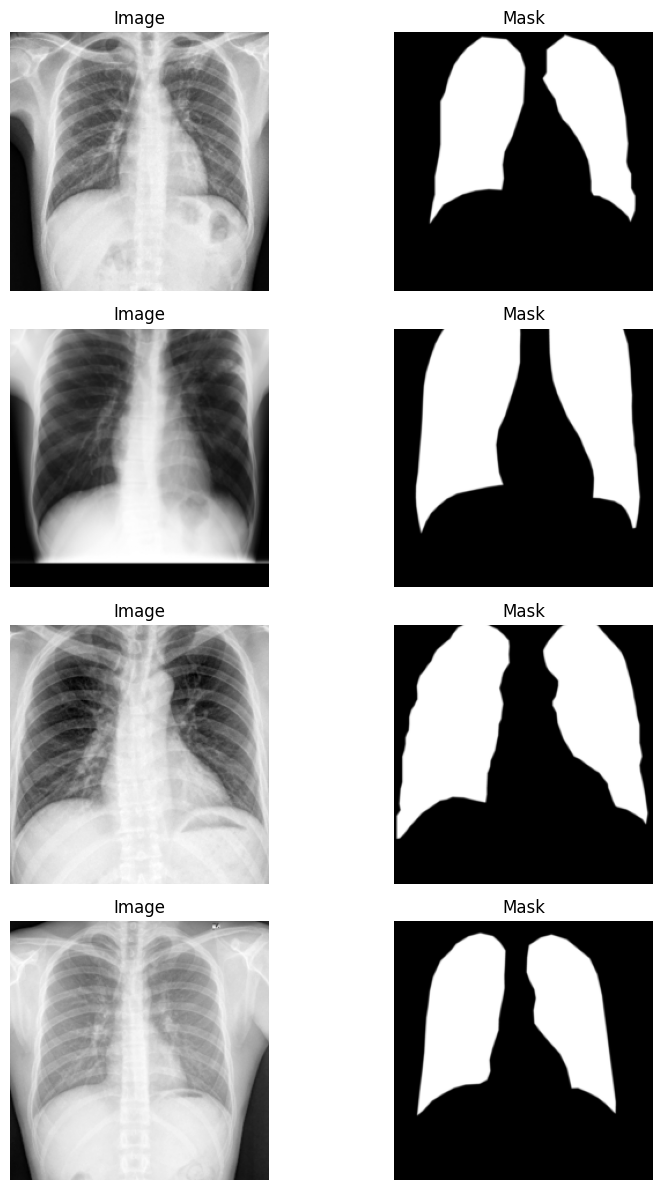

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(9, 12))
for  i in range(4):
    axes[i, 0].imshow((img[i].permute(1,2,0).numpy() * 255.).astype(np.uint8), cmap = "gray")
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow((label[i].permute(1,2,0).numpy() * 255.).astype(np.uint8), cmap = "gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
for img, label in train_loader_augment:
  Augmented_images = img
  Augmented_labels = label
  break

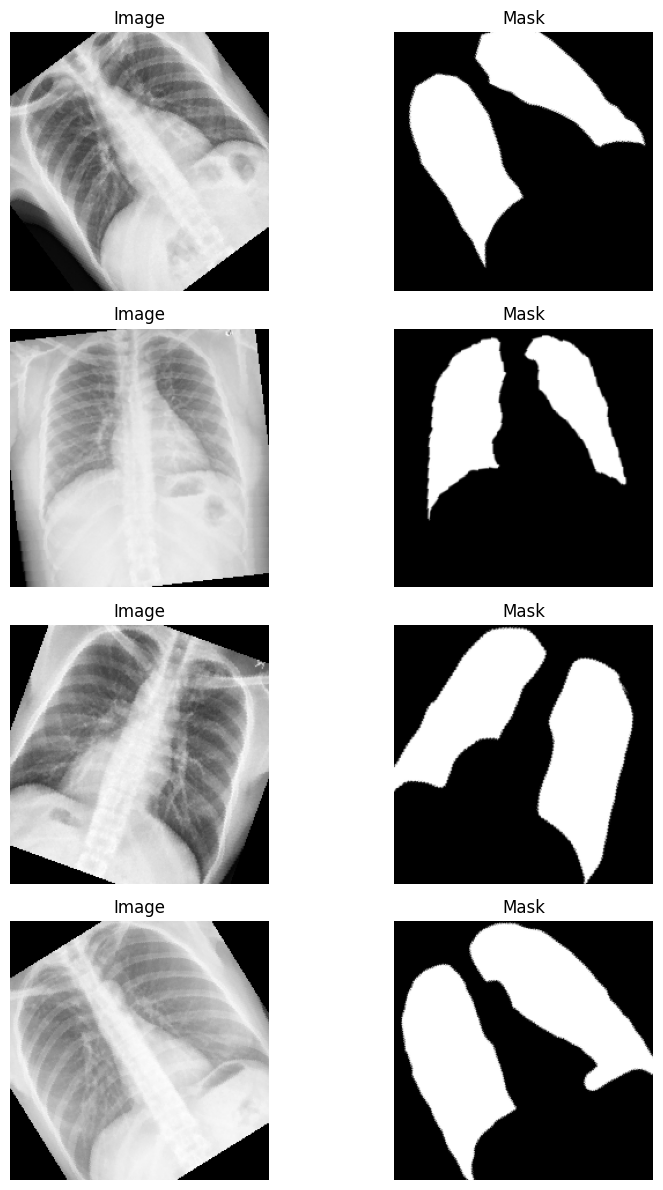

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(9, 12))
for  i in range(4):
    axes[i, 0].imshow((Augmented_images[i].permute(1,2,0).numpy() * 255.).astype(np.uint8), cmap = "gray")
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow((Augmented_labels[i].permute(1,2,0).numpy() * 255.).astype(np.uint8), cmap = "gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Model Architecture

For this dataset, the UNet model is used, as it was built as a medical segmentation model, which suits the dataset in use.

For building the UNet model, two Encoder_block and Decoder_block classes are defined, as the steps in the encoder and decoder have the same pattern and are repeated. In the original UNet model, no padding was used, but for the issue in hand, it is better to use padding so that the output of the model has the same size as the input of the model, because the dataset has same-sized image and mask. The encoder block will first perform a Conv2d followed by a ReLU activation function, then another Conv2d followed by a ReLU function and a MaxPool2d at the end. The input to the MaxPool2d is saved as identity and is returned by the class next to the output of the MaxPool2d layer.

In [ ]:
class Encoder_block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Encoder_block, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = "same")
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = "same")
        self.Maxpool = nn.MaxPool2d(kernel_size = 2,stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        identity = x
        out = self.Maxpool(x)

        return out, identity

In the Decoder_block, the model first uses a ConvTranspose and then concatenates the output of it with the identity of the encoder block. Then it applies a Conv2d followed by a ReLU activation function, then another Conv2d followed by a ReLU function, and outputs the result of the ReLU function. In the original UNet model, the Conv2d layers had no padding, but for this problem, padding is applied like the padding in the Encoder_block code. To have the same architecture as the original UNet model, the padding in both the Encoder and Decoder classes should be set to None, and the commented line in the Decoder_block's forward function should be uncommented. That line center-crops the identity the same way that it was performed in the original UNet model. This way, the encoder and decoder of the original model will be built, but as said before, for this problem the original UNet model won't be used.

In [ ]:
class Decoder_block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Decoder_block, self).__init__()

        self.convtranspose = nn.ConvTranspose2d(in_channel,out_channel, kernel_size = 2,stride=2)
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = "same")
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = "same")
        self.relu = nn.ReLU()

    def forward(self, x, identity):

        x = self.convtranspose(x)
        # identity = v2.CenterCrop(x.shape[2])(identity)
        x = self.conv1(torch.cat([x, identity], dim=1))
        x = self.relu(x)
        x = self.conv2(x)
        out = self.relu(x)

        return out

The Encoder_block and Decoder_block classes are used to build the UNet model. The input channel is set to 1 as it is a grayscale dataset. Also, the output convolution layer has one output channel to match the grayscale mask. The convolutions applied between the encoder and decoder blocks will have the same padding as in the encoder and decoder blocks. The model first uses four Encoder_blocks followed by a Conv2d, ReLU, Conv2d, ReLU sequence, four Decoder_blocks, and one Conv2d at the end. The output of the last Conv2d will be passed into a Sigmoid, and its output will be the output of the model. The way that the identities are passed is that the identity of the last encoder is passed into the first decoder, the identity of the third encoder into the second decoder, and so on. It should be said that this model will work on this dataset only with its 224-size image and mask. In case of a change of size, the model might have an error as the size of the image might become odd in the layers of the model, which cannot be halved with MaxPool2d and will have an error. If the model is to be used for another dataset, all the paddings should be set to None, and the commented line in the forward function of the decoder block should be uncommented.

In [ ]:
class UNet(nn.Module):
    def __init__(self, encoder_block, decoder_block):
      super(UNet, self).__init__()

      self.encoder_1 = self.make_encoder(encoder_block, 1, 64)
      self.encoder_2 = self.make_encoder(encoder_block, 64, 128)
      self.encoder_3 = self.make_encoder(encoder_block, 128,256)
      self.encoder_4 = self.make_encoder(encoder_block, 256,512)

      self.conv_1 = nn.Conv2d(512, 1024, kernel_size = 3, padding = "same")
      self.conv_2 = nn.Conv2d(1024, 1024, kernel_size = 3, padding = "same")

      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()

      self.decoder_1 = self.make_decoder(decoder_block, 1024, 512)
      self.decoder_2 = self.make_decoder(decoder_block, 512, 256)
      self.decoder_3 = self.make_decoder(decoder_block, 256, 128)
      self.decoder_4 = self.make_decoder(decoder_block, 128, 64)

      self.conv_3 = nn.Conv2d(64, 1, kernel_size = 1)



    def make_encoder(self, encoder_block, in_channel, out_channel):
      layers = []
      block = encoder_block(in_channel, out_channel)
      layers.append(block)
      return nn.Sequential(block)

    def make_decoder(self, decoder_block, in_channel, out_channel):
      layers = []
      block = decoder_block(in_channel, out_channel)
      layers.append(block)
      return block

    def forward(self, x):
      x, identity_1 = self.encoder_1(x)
      x, identity_2 = self.encoder_2(x)
      x, identity_3 = self.encoder_3(x)
      x, identity_4 = self.encoder_4(x)

      x = self.conv_1(x)
      x = self.relu(x)
      x = self.conv_2(x)
      x = self.relu(x)

      x = self.decoder_1(x, identity_4)
      x = self.decoder_2(x, identity_3)
      x = self.decoder_3(x, identity_2)
      x = self.decoder_4(x, identity_1)

      output = self.sigmoid(self.conv_3(x))

      return output

In [ ]:
model = UNet(Encoder_block, Decoder_block)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

UNet(
  (encoder_1): Sequential(
    (0): Encoder_block(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
    )
  )
  (encoder_2): Sequential(
    (0): Encoder_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
    )
  )
  (encoder_3): Sequential(
    (0): Encoder_block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
  

As seen in the summary of the model the output of the model has the same size as the input of the model.

In [ ]:
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
     Encoder_block-6  [[-1, 64, 112, 112], [-1, 64, 224, 224]]               0
            Conv2d-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
    Encoder_block-12  [[-1, 128, 56, 56], [-1, 128, 112, 112]]               0
           Conv2d-13          [-1, 256, 56, 56]         295,168
         

# Training

For training and validation, functions are written. In the training function, tqdm is used for better visualization of the model process. In the training function, model.train() is used to put the model in the training phase, and in the validation function, model.eval() is used to make the prediction. In the validation function, torch.no_grad() is used to make sure the weights aren't changed. The output of the training and validation functions is the loss of the epoch.

In [ ]:
from tqdm import tqdm
def train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    loader = tqdm(data_loader, total=len(data_loader))

    for batch, (X, y) in enumerate(loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      optimizer.zero_grad()
      loss = loss_fn(y_pred, y)
      losses.append(loss.item())

      loss.backward()
      optimizer.step()

      loader.set_postfix({"loss": loss.item()})

    return np.mean(losses)

In [ ]:
def val(model, data_loader, loss_fn, optimizer, device):
    model.eval()
    losses = []

    with torch.no_grad():
      for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        losses.append(loss.item())

    return np.mean(losses)

For the optimizer, Adam with a learning rate of 0.001 is used. An lr_scheduler.StepLR with step_size 5 and gamma 0.5 is defined. For the loss function, the MSELoss is chosen. Twenty epochs were chosen.

In [ ]:
epochs = 20
learning_rate = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In train_losses and validation_losses, the values of train_loss and val_loss are appended for each epoch to be able to plot the process of training after the training is done.

In [ ]:
train_losses = []
validation_losses = []

In [ ]:
for epoch in range(1, epochs+1):
  train_loss = train(model, train_loader, loss_fn, optimizer, device)
  val_loss = val(model, val_loader, loss_fn, optimizer, device)
  train_losses.append(train_loss)
  validation_losses.append(val_loss)
  scheduler.step()

  print(f"Epoch {epoch}/{epochs}:")
  print(f"Train - Loss: {train_loss}")
  print(f"Validation - Loss: {val_loss}")

100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.161]


Epoch 1/20:
Train - Loss: 0.18248703496323693
Validation - Loss: 0.13822823762893677


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.121]


Epoch 2/20:
Train - Loss: 0.14710842962894174
Validation - Loss: 0.1560860060983234


100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.0941]


Epoch 3/20:
Train - Loss: 0.12357543657223384
Validation - Loss: 0.0927604850795534


100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.0713]


Epoch 4/20:
Train - Loss: 0.08002297218061155
Validation - Loss: 0.072650622162554


100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.0599]


Epoch 5/20:
Train - Loss: 0.0543214472838574
Validation - Loss: 0.041564452565378614


100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.0324]


Epoch 6/20:
Train - Loss: 0.03782649260635177
Validation - Loss: 0.028400094558795292


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0228]


Epoch 7/20:
Train - Loss: 0.028806011451201305
Validation - Loss: 0.028551351485980883


100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.0297]


Epoch 8/20:
Train - Loss: 0.025238293533523876
Validation - Loss: 0.023779247370031144


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0174]


Epoch 9/20:
Train - Loss: 0.022276845294982195
Validation - Loss: 0.021896285729275808


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.00804]


Epoch 10/20:
Train - Loss: 0.02004813552937574
Validation - Loss: 0.021199769547416106


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0135]


Epoch 11/20:
Train - Loss: 0.018843280099746253
Validation - Loss: 0.020460212810171977


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0189]


Epoch 12/20:
Train - Loss: 0.018496626237821247
Validation - Loss: 0.019520778415931597


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0194]


Epoch 13/20:
Train - Loss: 0.017924418388348486
Validation - Loss: 0.01994591609885295


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0146]


Epoch 14/20:
Train - Loss: 0.017638673798905477
Validation - Loss: 0.019269435356060665


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0122]


Epoch 15/20:
Train - Loss: 0.016717332415282726
Validation - Loss: 0.01908885118448072


100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.0132]


Epoch 16/20:
Train - Loss: 0.016182273160666227
Validation - Loss: 0.0187709785790907


100%|██████████| 36/36 [00:24<00:00,  1.49it/s, loss=0.0176]


Epoch 17/20:
Train - Loss: 0.015935784723195765
Validation - Loss: 0.018541659745905135


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0175]


Epoch 18/20:
Train - Loss: 0.01579506638356381
Validation - Loss: 0.01884450639287631


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0122]


Epoch 19/20:
Train - Loss: 0.01603935009592937
Validation - Loss: 0.018397474351028602


100%|██████████| 36/36 [00:24<00:00,  1.48it/s, loss=0.0157]


Epoch 20/20:
Train - Loss: 0.01522202435363498
Validation - Loss: 0.018185401956240337


The training and validation losses are plotted to show the progression of the model through the epochs.

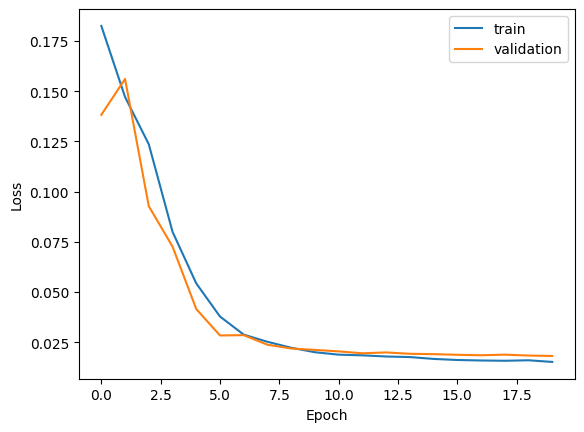

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation

The show_predictions function inputs a dataloader, models, and a number of images. The model_augment is set to None in case of there not being one. The function first iterates through the dataloader to get the image and mask. Then, it uses the models given to it to see the prediction of the models. After that, it will plot the image and mask with the predicted output of the models to see how they look compared to the ground truth (mask). The model_augment only works if it is passed into the function, and in case it isn't passed into it, the function will only use the model trained without the augmented training set for prediction.

In [ ]:
def show_predictions(dataloader, model, model_augment = None, num_images=5):
    data_iter = iter(dataloader)
    image, mask = next(data_iter)

    image = image.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        preds = model(image)
        if model_augment:
          preds_augment= model_augment(image)

    if model_augment:
      fig, axes = plt.subplots(num_images, 4, figsize=(9, 3*num_images))
    else:
      fig, axes = plt.subplots(num_images, 3, figsize=(9, 3*num_images))
    for i in range(num_images):
        counter = 0

        axes[i, counter].imshow((image[i].cpu().permute(1,2,0).numpy() * 255.).astype(np.uint8), cmap = "gray")
        axes[i, counter].set_title("Image")
        axes[i, counter].axis("off")
        counter += 1

        pred_img = (preds[i].cpu().permute(1,2,0).numpy() * 255.).astype(np.uint8)
        axes[i, counter].imshow(pred_img, cmap = "gray")
        axes[i, counter].set_title("Predicted Mask")
        axes[i, counter].axis("off")
        counter += 1

        if model_augment:
          pred_augment_img = (preds_augment[i].cpu().permute(1,2,0).numpy() * 255.).astype(np.uint8)
          axes[i, counter].imshow(pred_augment_img, cmap = "gray")
          axes[i, counter].set_title("Augmented Predicted Mask")
          axes[i, counter].axis("off")
          counter += 1

        axes[i, counter].imshow((mask[i].cpu().permute(1,2,0).numpy() * 255.).astype(np.uint8), cmap = "gray")
        axes[i, counter].set_title("Ground Truth")
        axes[i, counter].axis("off")

    plt.tight_layout()
    plt.show()


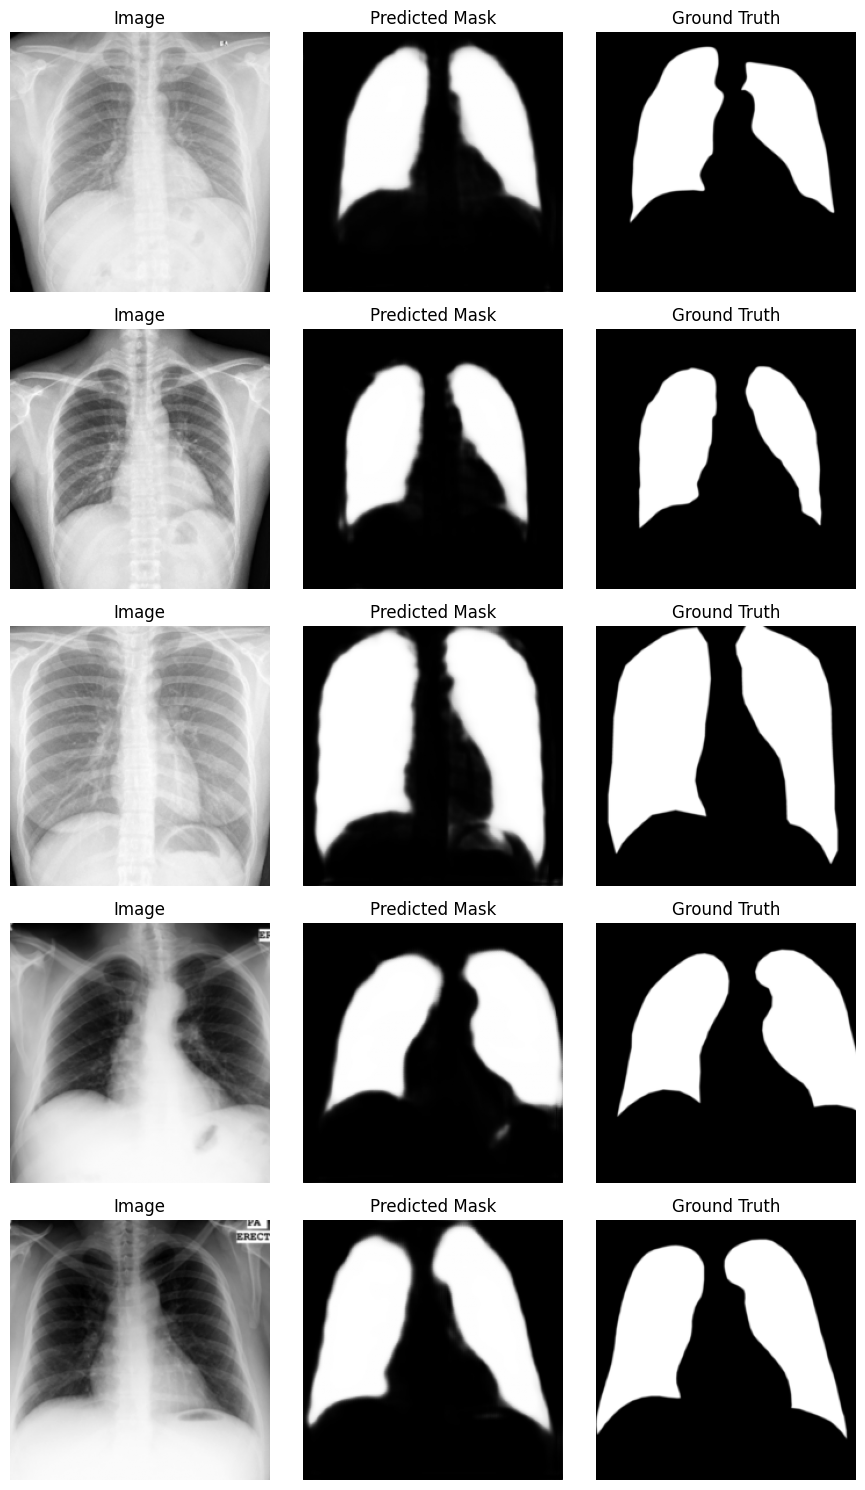

In [ ]:
show_predictions(dataloader = val_loader, model = model, num_images=5)

# Training with Augmentation

Another model is built to be trained with the augmented training set.

In [ ]:
model_augment = UNet(Encoder_block, Decoder_block)
model_augment.to(device)

UNet(
  (encoder_1): Sequential(
    (0): Encoder_block(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
    )
  )
  (encoder_2): Sequential(
    (0): Encoder_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
    )
  )
  (encoder_3): Sequential(
    (0): Encoder_block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (relu): ReLU()
  

For the optimizer, Adam with a learning rate of 0.001 is used. An lr_scheduler.StepLR with step_size 5 and gamma 0.5 is defined. For the loss function, the MSELoss is chosen. Twenty epochs were chosen.

In [ ]:
epochs = 20
learning_rate = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_augment.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In train_losses and validation_losses, the values of train_loss and val_loss are appended for each epoch to be able to plot the process of training after the training is done.

In [ ]:
train_losses = []
validation_losses = []

In [ ]:
for epoch in range(1, epochs+1):
  train_loss = train(model_augment, train_loader_augment, loss_fn, optimizer, device)
  val_loss = val(model_augment, val_loader, loss_fn, optimizer, device)
  train_losses.append(train_loss)
  validation_losses.append(val_loss)
  scheduler.step()

  print(f"Epoch {epoch}/{epochs}:")
  print(f"Train - Loss: {train_loss}")
  print(f"Validation - Loss: {val_loss}")

100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.141]


Epoch 1/20:
Train - Loss: 0.1842237123184734
Validation - Loss: 0.1513842973444197


100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.104]


Epoch 2/20:
Train - Loss: 0.13268431483043563
Validation - Loss: 0.16646123263570997


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.078]


Epoch 3/20:
Train - Loss: 0.09074521209630701
Validation - Loss: 0.10158451315429476


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0848]


Epoch 4/20:
Train - Loss: 0.08424459035611814
Validation - Loss: 0.08362921989626354


100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.102]


Epoch 5/20:
Train - Loss: 0.06839254115604693
Validation - Loss: 0.09215947323375279


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0721]


Epoch 6/20:
Train - Loss: 0.06672019221716458
Validation - Loss: 0.0733273650209109


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0615]


Epoch 7/20:
Train - Loss: 0.05976831561161412
Validation - Loss: 0.05673407680458493


100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.0319]


Epoch 8/20:
Train - Loss: 0.049099361110064715
Validation - Loss: 0.050730671319696635


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0348]


Epoch 9/20:
Train - Loss: 0.038347219944828086
Validation - Loss: 0.0345810672475232


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0263]


Epoch 10/20:
Train - Loss: 0.03440658561885357
Validation - Loss: 0.0376196066952414


100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.0237]


Epoch 11/20:
Train - Loss: 0.027633540694498353
Validation - Loss: 0.027142449799511168


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0251]


Epoch 12/20:
Train - Loss: 0.025449389540072944
Validation - Loss: 0.024063817742798064


100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.0389]


Epoch 13/20:
Train - Loss: 0.024958603291047946
Validation - Loss: 0.024646078339881368


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0165]


Epoch 14/20:
Train - Loss: 0.02338150019447009
Validation - Loss: 0.024389633494946692


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0318]


Epoch 15/20:
Train - Loss: 0.024360599151502054
Validation - Loss: 0.024089037337236933


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0203]


Epoch 16/20:
Train - Loss: 0.022184511077486806
Validation - Loss: 0.021318691575692758


100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.0155]


Epoch 17/20:
Train - Loss: 0.02125566910641889
Validation - Loss: 0.021609916869137023


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0112]


Epoch 18/20:
Train - Loss: 0.020848275834901467
Validation - Loss: 0.02108793891966343


100%|██████████| 36/36 [00:24<00:00,  1.46it/s, loss=0.0145]


Epoch 19/20:
Train - Loss: 0.020641918087171182
Validation - Loss: 0.02119571612113052


100%|██████████| 36/36 [00:24<00:00,  1.47it/s, loss=0.0145]


Epoch 20/20:
Train - Loss: 0.0202699672534234
Validation - Loss: 0.020948148229055934


The training and validation losses are plotted to show the progression of the model through the epochs.

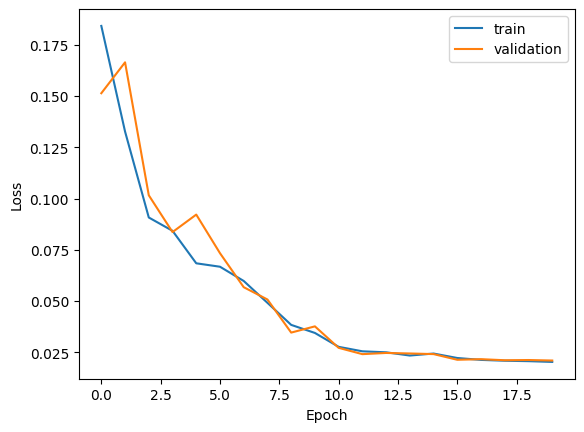

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation with augmentation

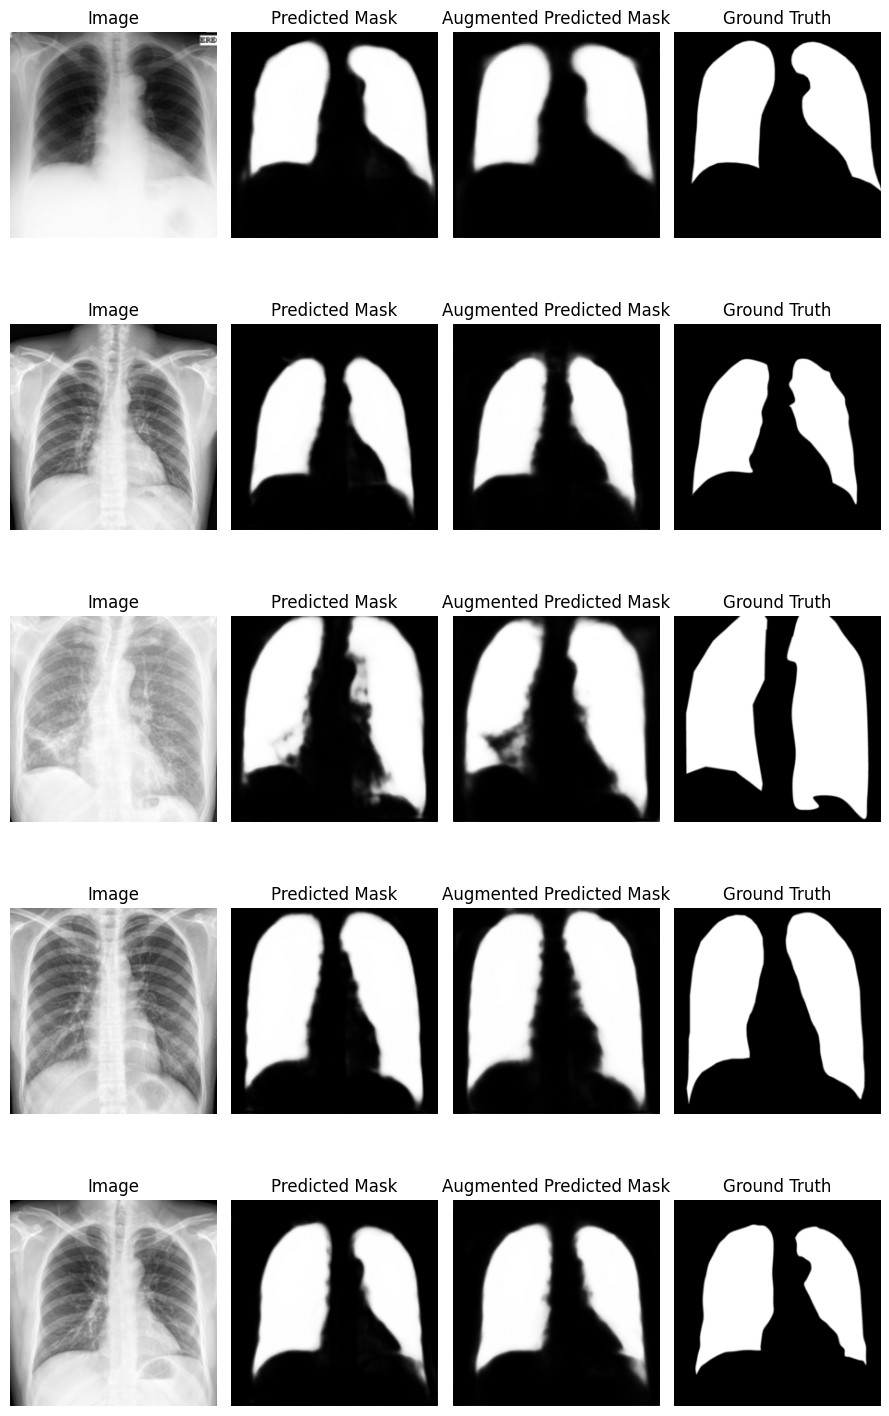

In [ ]:
show_predictions(val_loader, model, model_augment, num_images=5)

# Conclusion

As it can be seen in the results, both models have achieved a decent loss.

MSE loss no Augmentation: $0.0181$

MSE loss with Augmentation: $0.0209$

The model without augmentation has a lower loss value, but it has a bit of overfitting and doesn't generalize as good as the model with augmentation. This could be seen from the difference between the loss functions of the training and validation set:

Model without augmentation: $0.0030$

Model with augmentation: $0.0006$

This difference can also be seen in the plots, as the model with augmentation has a better generalization. It is predicted that with more epochs the augmented model will perform better as the model without augmentation might overfit more.